## Cargo la superficie

Number of particles in file /home/lucas/Documents/Proyecto_Integrador/PI/resampleo_trackfiles/trackfile1/surface_source.h5: 454961
100% n, 0% g, 0% e-, 0% e+, 0% p, 
Macrogrupo 1: rango [2.996, 2.998) → peso = 254986.0, 60.03%
Cantidad de partículas con letargia mínima (2.996): 248361
Macrogrupo 2: rango [2.998, 3.063) → peso = 56912.0, 13.40%
Macrogrupo 3: rango [3.063, 4.186) → peso = 83327.0, 19.62%
Macrogrupo 4: rango [4.186, 21.246) → peso = 29548.0, 6.96%


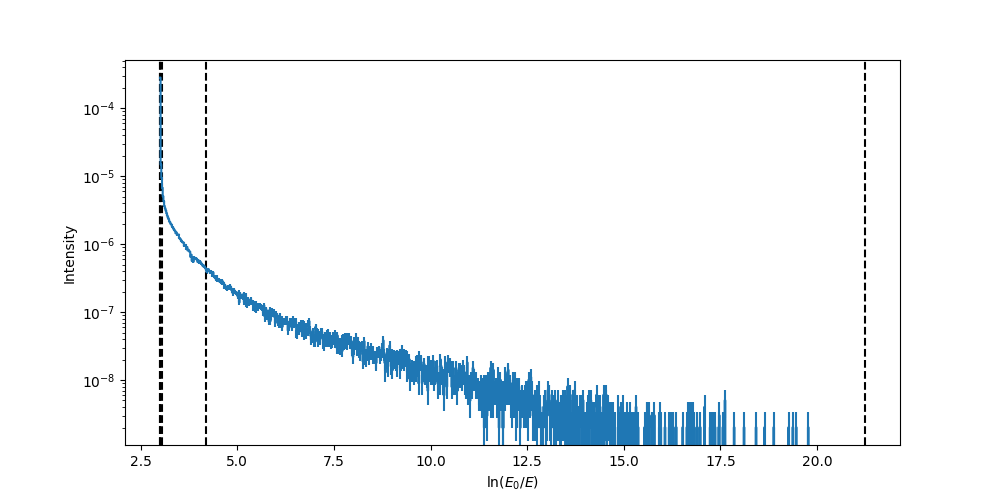

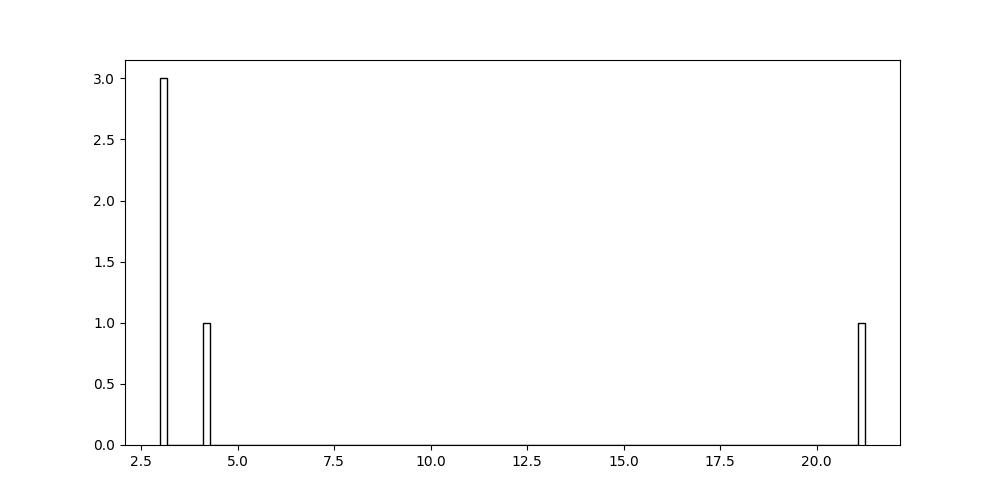

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import kdsource.surfsource as kds
import kdsource.histograms as kdh

plt.close('all')

ss = kds.SurfaceSourceFile(
    "/home/lucas/Documents/Proyecto_Integrador/PI/resampleo_trackfiles/trackfile1/surface_source.h5",
    domain={"w": [0, 2]},
)

fine_bins = int(1e4)
var = "ln(E0/E)"

letargia = ss._df2[var].to_numpy()
pesos = ss._df2["wgt"].to_numpy()

edges = kdh._adaptive_edges(
    x = letargia,
    n_bins = 4,
    w = pesos,
    initial_bins = 1,
    fine_bins = fine_bins,
)
# calcular suma de pesos en cada subgrupo definido por ‘edges’
pesos_subgrupos, _ = np.histogram(letargia, bins=edges, weights=pesos)
total = pesos.sum()

# imprimir el peso y porcentaje de cada macrogrupo
for i, (wgt, lo, hi) in enumerate(zip(pesos_subgrupos, edges[:-1], edges[1:]), start=1):
    pct = wgt/total*100
    print(f"Macrogrupo {i}: rango [{lo:.3f}, {hi:.3f}) → peso = {wgt:.1f}, {pct:.2f}%")

    if i == 1:
        n_min = np.count_nonzero(letargia == letargia.min())
        print(f"Cantidad de partículas con letargia mínima ({letargia.min():.3f}): {n_min}")

%matplotlib widget

plt.figure(figsize=(10, 5))
ss.plot_distribution(
    vars=[var],
    bins=[int(fine_bins/10)],
    scales=["linear", "log"],
)
# plt.xscale("log")
for edge in edges:
    plt.axvline(x=edge, linestyle='--', color='k')

# plt.hist(
#     letargia,
#     bins=edges,
#     weights=pesos*1e-12*1.38/2*3,
#     histtype='stepfilled',
#     color='red',
#     alpha=0.3,
#     # density=True,
# )
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(edges, bins=100, histtype='step', color='k')
plt.show()
